# Classical Shadow

In [1]:
from data_acquisition_shadow import randomized_classical_shadow, derandomized_classical_shadow
# from prediction_shadow import estimate_exp


from qutip.measurement import measure, measurement_statistics, measure_observable
from qutip import *

import sys, random
from math import pi
import numpy as np
np.set_printoptions(precision=4)

from qutip.qip.operations import snot, sqrtnot, phasegate

pauli_dict = {'I': identity(2), 'X': sigmax(), 'Y': sigmay(), 'Z': sigmaz()}
# sqrtz = phasegate(pi/2)
# sqrtZ = Qobj([[1,0],[0,-1.j]])
eignY = Qobj([[1,1],[1.j,-1.j]])
pauli_basis_dict = {'X': snot(), 'Y': eignY, 'Z': identity(2)}

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 11  #default 10
LARGE_SIZE = 13
plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels

def str2pauliop(string_list: list):
    return tensor([pauli_dict[item] for item in string_list])

def load_observables_file(filename):
    with open(filename) as f:
        content = f.readlines()
    system_size = int(content[0])

    all_observables = []
    for line in content[1:]:
        one_observable = []
        for pauli_XYZ, position in zip(line.split(" ")[1::2], line.split(" ")[2::2]):
            one_observable.append((pauli_XYZ, int(position)))
        all_observables.append(one_observable)

    return all_observables

def pauli2basis(string_list: list):
    eigen_unitary = tensor([pauli_basis_dict[pauli_xyz] for pauli_xyz in string_list])
    # print(eigen_unitary)
    return eigen_unitary

def load_measurements_file(filename):
    with open(filename) as f:
        measurements = f.readlines()
    system_size = int(measurements[0])

    full_measurement = []
    for line in measurements[1:]:
        single_meaurement = []
        for pauli_XYZ, outcome in zip(line.split(" ")[0::2], line.split(" ")[1::2]):
            single_meaurement.append((pauli_XYZ, int(outcome)))
        full_measurement.append(single_meaurement)

    return full_measurement

def format_observable(loca_pauli_observable:str):
    observable = []
    for index,pauli_op in enumerate(list(loca_pauli_observable)):
        if pauli_op != 'I':
            observable.append((pauli_op,index))
    return observable


def estimate_exp(full_measurement, one_observable):
    sum_product, cnt_match = 0, 0

    for single_measurement in full_measurement:
        not_match = 0
        product = 1

        # print(one_observable)
        for pauli_XYZ, position in one_observable:
            if pauli_XYZ != single_measurement[position][0]:
                not_match = 1
                break
            product *= single_measurement[position][1]
        if not_match == 1: continue

        # print(f'single_measurement: {single_measurement}; one_observable: {one_observable}; product: {product}')

        sum_product += product
        cnt_match += 1

    return sum_product, cnt_match

def estimate_expectation_with_shadow(observables,measurement_scheme,n_qubit,state):
    print('============ estimate_expectation_with_shadow ==============')
    print(f'observable: {len(observables)}, shadow size: {len(measurement_scheme)}, number of qubits: {n_qubit}')
    error_list = []
    for observable in observables:
        local_observable_string = ['I' for i in range(n_qubit)]
        for pauli_XYZ, position in observable:
            local_observable_string[int(position)] = pauli_XYZ
        local_observable = str2pauliop(local_observable_string)
        # print(one_observable)
        sum_product, cnt_match = estimate_exp(measurement_scheme, observable)
        shadow_estimation = sum_product / cnt_match
        # print(f'sum_product, cnt_match: {sum_product, cnt_match}')
        exact_expectation = expect(oper=local_observable,state=state)
        print(
            f'observable: {observable}, expectation: {exact_expectation}, shadow estimation: {shadow_estimation:.3f}'
        )
        error_list.append((exact_expectation-shadow_estimation)**2)
    return error_list

def measure_pauli_basis(state,n_qubit,pauli_measure_str):
    assert n_qubit == len(state.dims[0])
    eigen_unitary = pauli2basis(list(pauli_measure_str))
    # print(eigen_unitary)
    rotated_state = eigen_unitary.dag() * state * eigen_unitary
    # print(f'rotated_state: {rotated_state}, trace: {rotated_state.tr()}')
    # print([rotated_state[index,index] for index in range(2**n)])
    prob_list = sum([[index]*round(1000*rotated_state[index,index].real) for index in range(2**n)],[]) # flatten the list
    # print(prob_list)
    measurement_result_int = random.choice(prob_list)
    measurement_result_bin = "{0:b}".format(measurement_result_int)
    measurement_result = '0'*(n-len(measurement_result_bin)) + measurement_result_bin
    evalues = [(-1)**int(bit) for bit in measurement_result]
    # print(f'binary string: {measurement_result}, evalues: {evalues}, int: {measurement_result_int}')

    return [(pauli_measure_str[index],evalues[index]) for index in range(n_qubit)]

def generate_measurement_results(observables,shadow_size,state,n_qubit,derandomized=True):

    print('============ generate_measurement_results ==============')
    if derandomized:
        pauli_measurement_ensemble = derandomized_classical_shadow(all_observables=observables, num_of_measurements_per_observable=shadow_size, system_size=n_qubit)[:shadow_size]
        print(f'derandomized shadow size: {len(pauli_measurement_ensemble)}')
    else: 
        pauli_measurement_ensemble = randomized_classical_shadow(num_total_measurements=shadow_size,system_size=n_qubit)
        print(f'randomized shadow size: {len(pauli_measurement_ensemble)}')
    # print(pauli_measurement_ensemble)
    measurement_results = []
    for index,pauli_measurement in enumerate(pauli_measurement_ensemble):
        if index % 100 == 0:
            print(index, end ="-->") 
        # print(''.join(pauli_measurement))
        one_measurement_result = measure_pauli_basis(state=state, n_qubit=n_qubit, pauli_measure_str=''.join(pauli_measurement))
        measurement_results.append(one_measurement_result)

    return measurement_results

## Five singlets: Huang's example

In [66]:
## 10-qubit state
n = 10
five_singlet = ket2dm(tensor([singlet_state() for i in range(5)]))

## laod measurement_scheme from file from GitHub repo
# measurement_results = load_measurements_file('measurement_10.txt')

## select randomized or derandomized
all_observables = load_observables_file('observables_10.txt')
measurement_results = generate_measurement_results(observables=all_observables,shadow_size=1000,state=five_singlet,n_qubit=n,derandomized=True)

# print(f'number of observables: {len(all_observables)}; {all_observables}')

estimate_expectation_with_shadow(observables=all_observables,
                                 measurement_scheme=measurement_results,
                                 n_qubit=10,
                                 state=five_singlet)

============ generate_measurement_results ==============
derandomized shadow size: 1000
0-->100-->200-->300-->400-->500-->600-->700-->800-->900-->============ estimate_expectation_with_shadow ==============
observable: 16, shadow size: 1000, number of qubits: 10
observable: [('X', 0), ('Y', 1)], expectation: 0.0, shadow estimation: -0.030
observable: [('X', 1), ('Y', 2)], expectation: 0.0, shadow estimation: -0.051
observable: [('X', 2), ('Y', 3)], expectation: 0.0, shadow estimation: 0.096
observable: [('X', 3), ('Y', 4)], expectation: 0.0, shadow estimation: -0.042
observable: [('X', 4), ('Y', 5)], expectation: 0.0, shadow estimation: 0.081
observable: [('X', 5), ('Y', 6)], expectation: 0.0, shadow estimation: 0.081
observable: [('X', 6), ('Y', 7)], expectation: 0.0, shadow estimation: 0.015
observable: [('X', 7), ('Y', 8)], expectation: 0.0, shadow estimation: 0.012
observable: [('X', 8), ('Y', 9)], expectation: 0.0, shadow estimation: 0.002
observable: [('X', 0), ('Y', 4)], expecta

## Test other states

number of observables: 30; [[('X', 0), ('X', 1)], [('X', 1), ('X', 2)], [('X', 1), ('X', 3)], [('X', 0), ('X', 2)], [('X', 0), ('X', 3)], [('X', 0), ('X', 1)], [('X', 1), ('Z', 2)], [('Z', 0), ('X', 2)], [('Z', 2), ('X', 3)], [('X', 0), ('Z', 1)], [('X', 0), ('Z', 2)], [('X', 0), ('Z', 3)], [('Y', 1), ('Y', 2)], [('Y', 0), ('Y', 2)], [('Y', 2), ('Y', 3)], [('Y', 0), ('Y', 1)], [('Y', 0), ('Y', 2)], [('Y', 0), ('Y', 3)], [('Z', 1), ('Y', 2)], [('Y', 0), ('Z', 2)], [('Y', 2), ('Z', 3)], [('Z', 0), ('Y', 1)], [('Z', 0), ('Y', 2)], [('Z', 0), ('Y', 3)], [('Z', 0), ('Z', 2)], [('Z', 0), ('Z', 1)], [('Z', 1), ('Z', 2)], [('Z', 1), ('Z', 2)], [('Z', 2), ('Z', 3)], [('Z', 1), ('Z', 3)]]
=============== naive estimation ================
error_list: [0.1996731670303766, 0.050494992892614485, 0.10848846943704253, 0.023513861117059384, 0.004801158034734557, 0.16834184048315043, 0.03277118824021049, 0.018424639217192017, 0.028890119682582788, 0.14578722042147332, 0.017586458388601536, 0.05783395194

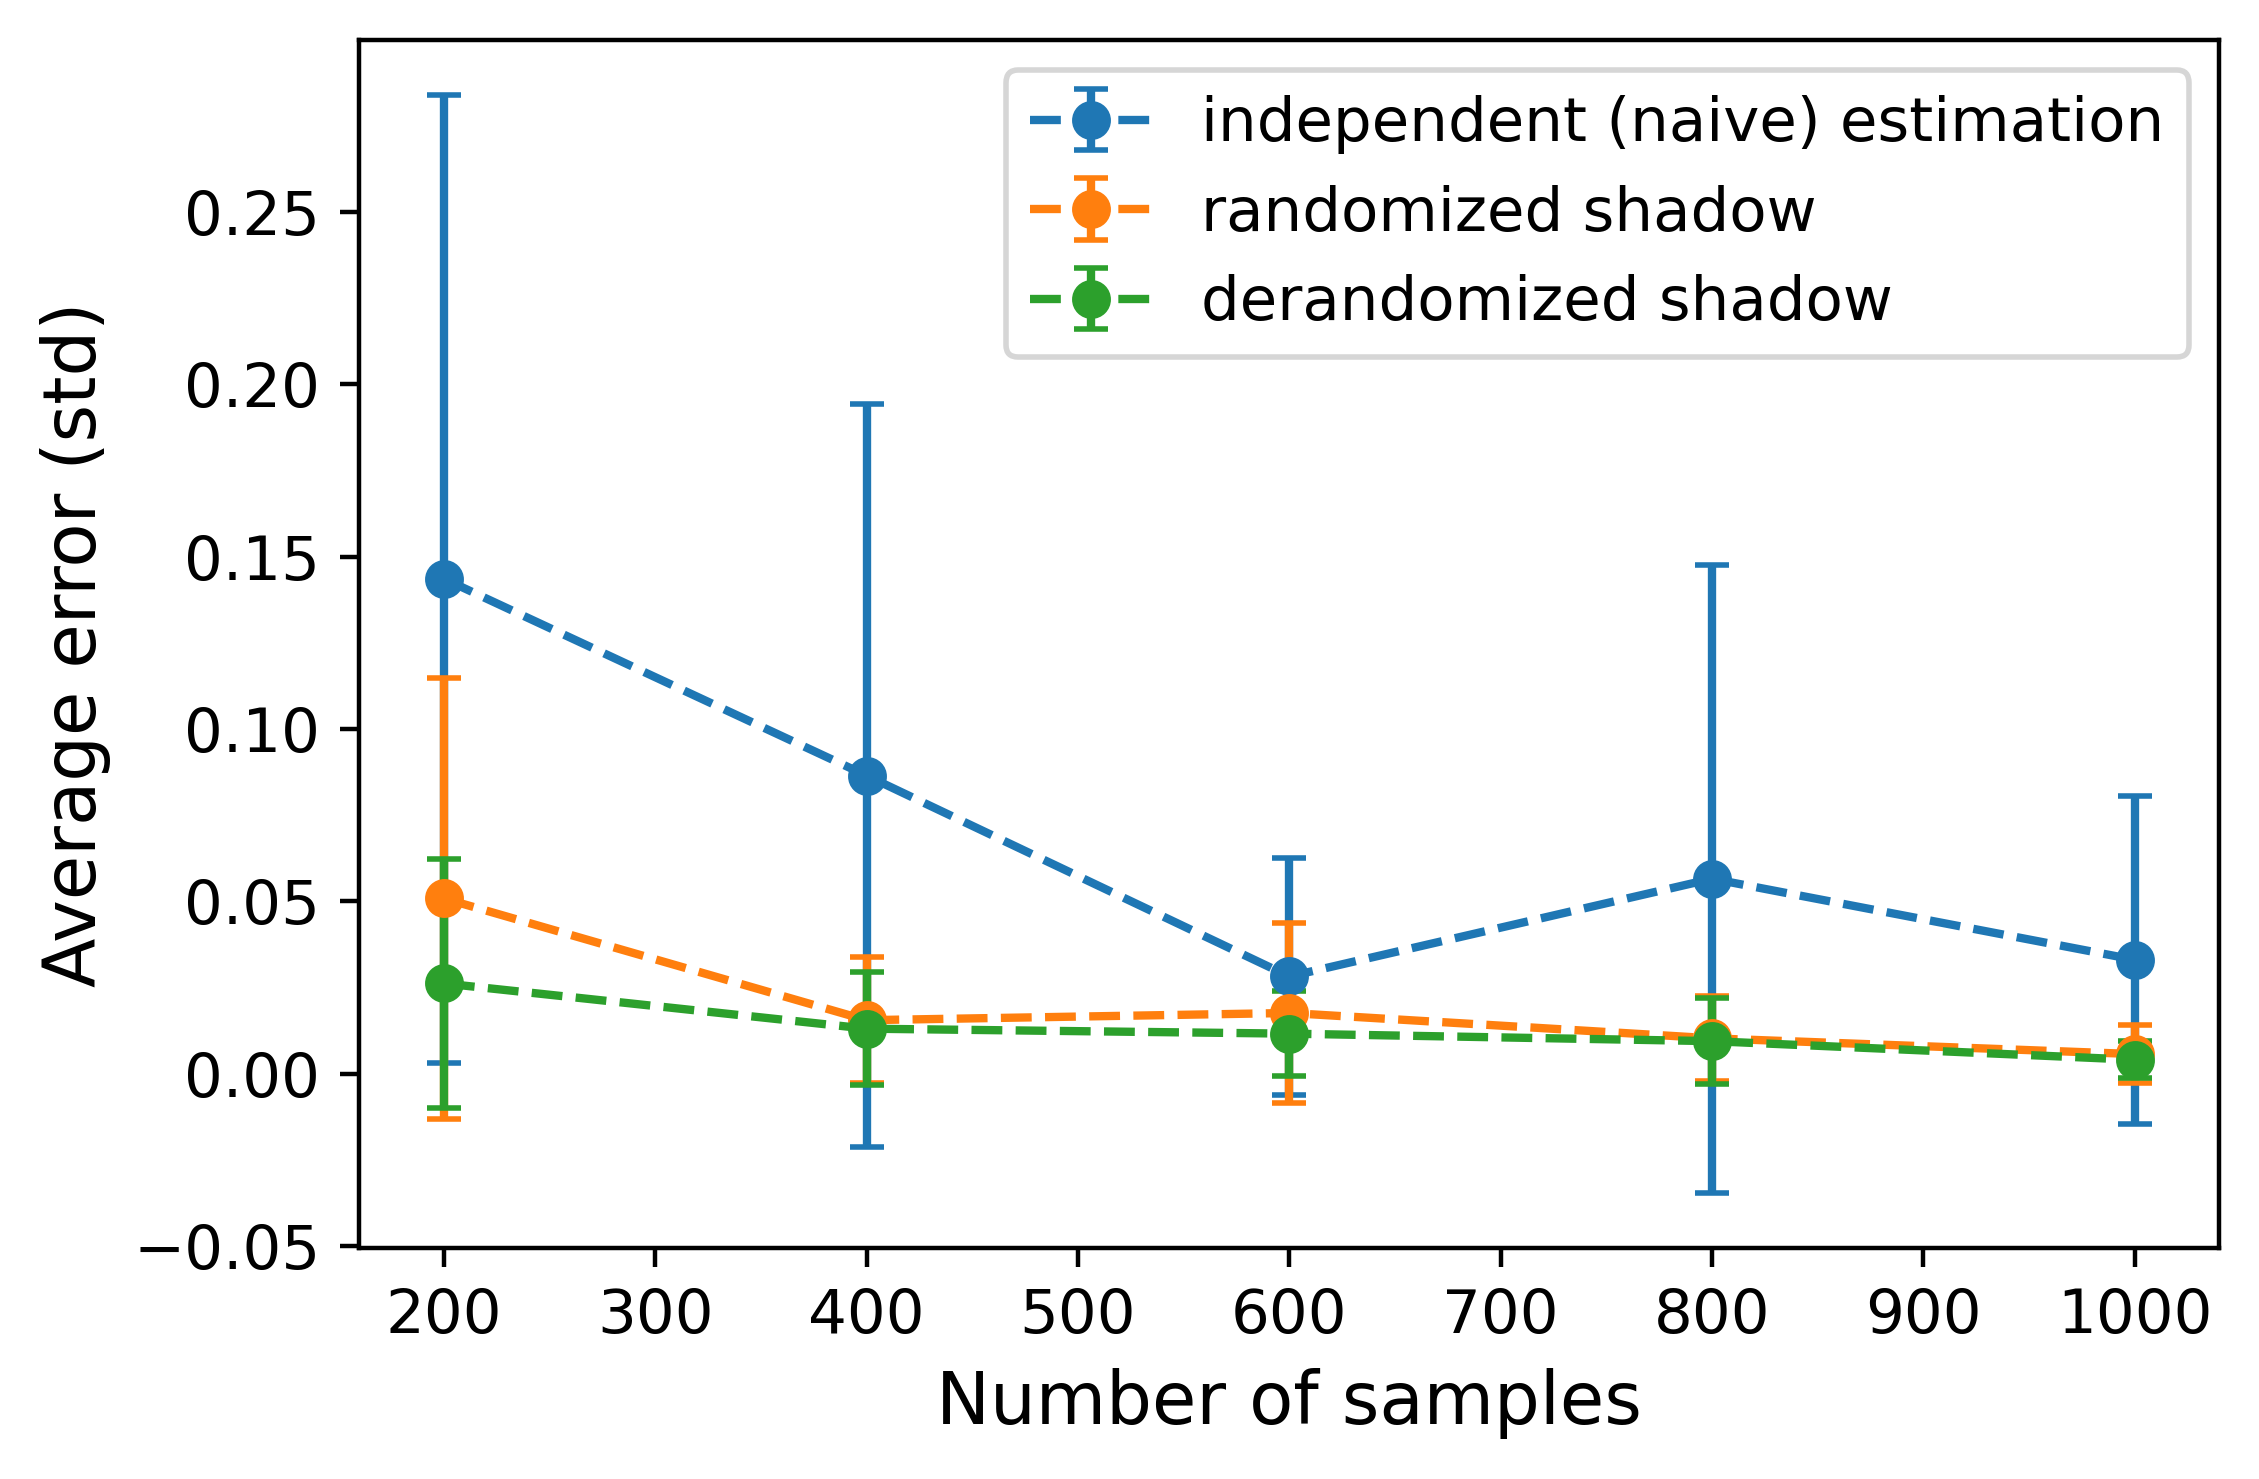

In [2]:
# import itertools
# Swap function
def swapPositions(list, pos1, pos2):
     
    list[pos1], list[pos2] = list[pos2], list[pos1]
    return list

permutations = [[1,2], [1,3], [1,4], [2,3], [2,4], [3,4]]
test_observables = []
for item in ['XXII','XIZI', 'YIYI', 'ZIYI', 'IZZI']:
    # print(list(itertools.permutations(item)))
    
    test_observables = test_observables + [''.join(swapPositions(list(item), position[0]-1, position[1]-1)) for position in permutations]

# test_observables = ['XX']
all_observables = [
    format_observable(pauli_ob_str) for pauli_ob_str in test_observables
]
n = 4
test_rand_dm = rand_dm(N=2**n,dims=[[2]*n,[2]*n])

# n = 10
# test_rand_dm = rand_dm(N=2**n,dims=[[2]*n,[2]*n])
# # test_rand_dm = ket2dm(w_state(N=10))
# all_observables = load_observables_file('observables_10.txt')

print(f'number of observables: {len(all_observables)}; {all_observables}')

shadow_size_list = [200, 400, 600, 800, 1000]
for scheme in ['naive',False,True]:
    y = []
    e = []
    for shadow_size in shadow_size_list:
        if scheme == 'naive':
            print('=============== naive estimation ================')
            error_list = []
            for test_observable in test_observables:
                outcomes = []
                pauli_observable = str2pauliop(list(test_observable))
                exact_expectation = expect(oper=pauli_observable, state=test_rand_dm)
                ## repeat shadow_size/len(test_observables) times for each observable
                for i in range(round(shadow_size/len(test_observables))):
                    outcome, collapsed_state = measure_observable(
                        state=test_rand_dm, op=pauli_observable)
                    outcomes.append(outcome)
                error_list.append((exact_expectation - np.mean(outcomes))**2)
                    
        else:
            measurement_results = generate_measurement_results(observables=all_observables,
                                                            shadow_size=shadow_size,
                                                            state=test_rand_dm,
                                                            n_qubit=n,
                                                            derandomized=scheme)
            # print(randomized_measurement_scheme)
            error_list = estimate_expectation_with_shadow(observables=all_observables,
                                            measurement_scheme=measurement_results,
                                            n_qubit=n,
                                            state=test_rand_dm)

        print('error_list:', error_list)
        y.append(np.mean(error_list))
        e.append(np.std(error_list))

    plt.errorbar(shadow_size_list, y, e, linestyle="dashed", marker="o",  capsize=3)
plt.xlabel('Number of samples')
plt.ylabel('Average error (std)')
plt.legend(['Independent estimation','Randomized shadow','Derandomized shadow'])
plt.savefig('estimation_error_compare_methods.png', dpi=400, bbox_inches='tight')
plt.show()

In [104]:
bell11 = bell_state(state='11')
test_measurement = ['X', 'X']
# print(test_measurement)
# measurement_statistics(state=bell11,ops=str2pauliop(test_measurement))
outcome, collapsed_state = measure_observable(state=bell11,op=str2pauliop(test_measurement))
outcome

-0.9999999999999989

In [95]:
## my wrong attempts

def single_copy_measurement(state,pob):
    measure_observable(state, pob)
    eigenvalues, eigenstates, probabilities = measurement_statistics(state, pob)

    print('probabilities of two outcomes:',(1-np.inner(eigenvalues, probabilities))/2,(1+np.inner(eigenvalues, probabilities))/2)
    return 1 if random.random() < (1+np.inner(eigenvalues, probabilities))/2 else -1


def projector_measure(state, n_qubit):
    state_0, state_1 = basis(2, 0), basis(2, 1)
    Z0, Z1 = ket2dm(state_0), ket2dm(state_1)
    assert n_qubit == len(state.dims[0])
    print(f'dimension: {state.dims}, number of qubits: {n_qubit}')

    projector_Z0 = [Z0] + [identity(2) for i in range(n_qubit - 1)]
    projector_Z1 = [Z1] + [identity(2) for i in range(n_qubit - 1)]
    projector = [tensor(projector_Z0), tensor(projector_Z1)]

    collapsed_states, probabilities = measurement_statistics(state=state,
                                                             ops=projector)
    print(probabilities)

# projector_measure(op_state,n)


In [80]:
## shell commands
# python data_acquisition_shadow.py -r 30 5
# python data_acquisition_shadow.py -d 10 generated_observables_3.txt
# python generate_observables.py
# python prediction_shadow.py -o measurement.txt observables.txt

## Versions of software package/module 